# 05 - Taming Text

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from  email.parser import FeedParser
%matplotlib inline

## Part 1: Word cloud

### Email corpus extraction

As we are not intersted in every details (like the sender/receiver, etc..) our first task is to extract the body of the emails.

First let's read the Emails.csv file

In [4]:
mails = pd.read_csv("hillary-clinton-emails/Emails.csv")

In [5]:
mails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...",UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\r\nU.S. Department of State\r\nCa...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\r\nFriday, March 1...",B6\r\nUNCLASSIFIED\r\nU.S. Department of State...


Now we have two options: take the raw text or use the extracted body, but since the content of the raw text seems to be messy (further inspections confirmed this) and as some people already did the work for us, we are going to use the extracted bodies.

In [94]:
emailsBody = mails['ExtractedBodyText'].dropna()
print(len(emailsBody))
emailsBody.head()

6742


1    B6\r\nThursday, March 3, 2011 9:45 PM\r\nH: La...
2                                                  Thx
4    H <hrod17@clintonemail.com>\r\nFriday, March 1...
5    Pis print.\r\n-•-...-^\r\nH < hrod17@clintoner...
7    H <hrod17@clintonemail.corn>\r\nFriday, March ...
Name: ExtractedBodyText, dtype: object

We then lower case everything (no important information is lost with this and it may avoid us troubles, plus better uniformity)

In [97]:
emailsBody = emailsBody.apply(lambda x: x.lower())

We need the data to be represented in a single string, so we first merge all the cells in a single array and then merge that array in a single string

In [98]:
textArray = emailsBody.values.flatten()
textString = ' '.join(textArray)

The first method is straightforward, generate a cloud directly from the unprocessed, untokenized string

In [99]:
cloud = WordCloud().generate(textString)
#cloud = WordCloud(max_font_size=40).generate(rawTextString) limits size of biggest word

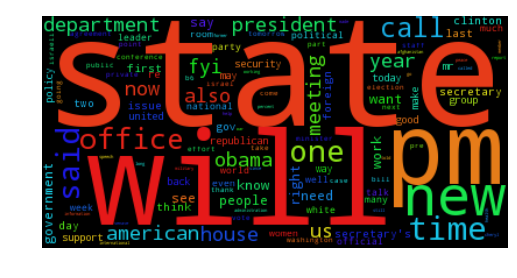

In [100]:
plt.imshow(cloud)
plt.axis('off')
plt.show()

This word cloud shows what we could expect from such emails (state, office, Obama, ...) but also a lot of noisy words that do not give relevant informations, such as 'will', 'said', 'call', etc.. The next steps are intended to improve the cloud.

We will now tokenize the entire string, Regexp does the big of the tokenization, while "stop_words" will get rid of useless words like "the", "and"...

In [102]:
#tokens = nltk.word_tokenize(rawTextString)
tokenizer = RegexpTokenizer(r'\w+')
allTokens = tokenizer.tokenize(textString)
print("Number of tokens: ", len(allTokens))

Number of tokens:  626330


In [105]:
en_stop = get_stop_words('en')
#We'll add a few uninteresting words in the list to remove
#en_stop.extend(('U','S','No','NO', 'F'))
tokens = [i for i in allTokens if not i in en_stop]
print("Number of tokens after stop word filtering: ", len(swTokens))

Number of tokens after stop word filtering:  2278654


In [106]:
print("Remaining tokens: ", round(len(tokens) / len(allTokens) * 100), "%")

Remaining tokens:  61 %


The stop words filtering got rid of 39% of the tokens, which is quite big.

Now that nltk got rid of unecessary data for us, we'll merge the array back into a string and use wordcloud again

In [107]:
cleanString = ' '.join(tokens)

In [108]:
cleanCloud = WordCloud().generate(cleanString)

Raw


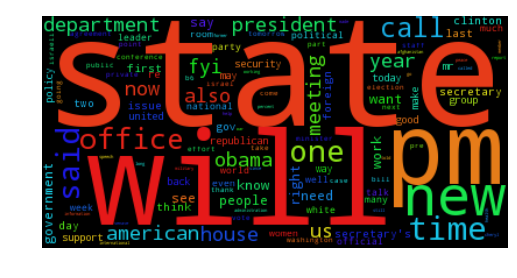

Stopwords cleaned


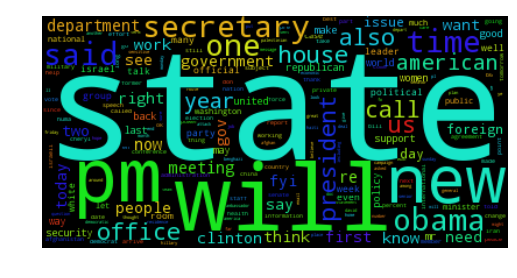

In [112]:
print("Raw")
plt.imshow(cloud)
plt.axis('off')
plt.show()
print("Stopwords cleaned")
plt.imshow(cleanCloud)
plt.axis('off')
plt.show()

It is slightly better, but still quite the same as removing the stop words gave more fairness to the weight distribution of words.

By observing the tokens

## PART 3

In [ ]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

The dictionary function will assign and ID to each token and do word counting.
doc2bow converts a dictionary into a (word_id, word_frequency) tuple

In [ ]:
dictionary = Dictionary([tokens])
corpus = [dictionary.doc2bow(text) for text in [tokens]]

We will now use the lda function from 5 to 50, printing the topic at each step

In [ ]:
for topics in range(5,50):
    lda = LdaModel(corpus, num_topics=topics, id2word = dictionary)
    print(lda.print_topics(num_topics=5, num_words=3))